In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# Machine learning management
import mlflow
from mlflow.models.signature import infer_signature

# Visualização de dados
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipeline para tratar dados futuros
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2' : metrics.r2_score(y_true, y_pred),
        'MAE' : metrics.mean_absolute_error(y_true, y_pred),
        'MAPE' : metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE' : np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
    }
    return dict_metrics

In [3]:
df = pd.read_csv("../data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Modeling

In [4]:
# Separando features numericas de categoricas e definindo o targert
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
TARGET = 'charges'

In [5]:
# Base de Treino
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [6]:
# Def preprocessor
numerical_transfomer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transfomer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transfomer, NUMERICAL_FEATURES),
    ('cat', categorical_transfomer, CATEGORICAL_FEATURES)
]).set_output(transform='pandas')



In [7]:
# Transform
preprocessor.fit_transform(X_train).head(1)

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northeast,cat__region_northwest,cat__region_southeast,cat__region_southwest
1068,0.978261,0.153349,0.2,1.0,0.0,0.0,1.0,0.0,0.0


In [8]:
# Def models
models = {
    'Dummy' : DummyRegressor(),
    'LinearRegression' : LinearRegression(),
    'LassoCV' : LassoCV(),
    'RidgeCV': RidgeCV(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'GradientBoostingRegressor' :GradientBoostingRegressor()
}

In [9]:
# Criando experimento
mlflow.set_experiment('Insurance')

2023/10/27 21:46:10 INFO mlflow.tracking.fluent: Experiment with name 'Insurance' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///workspaces/google_app_ml_deploy/7-MLFlow/notebooks/mlruns/366868970861931894', creation_time=1698443170801, experiment_id='366868970861931894', last_update_time=1698443170801, lifecycle_stage='active', name='Insurance', tags={}>

In [ ]:
for model_name, model in models.items():

    # Model pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train model
    model_pipeline.fit(X_train, y_train)
    # Get model prdictions
    y_pred = model_pipeline.predict(X_test)
    model_metrics = get_metrics(y_test, y_pred)
    # Get model paramaters
    model_params = model_pipeline.named_steps['model'].get_params()

    #MLFlow
    with mlflow.start_run():
        # Log métricas do modelo
        mlflow.log_metrics(model_metrics)
        # Log hiperparâmetros do mdoelo
        mlflow.log_params(model_params)

        # Log figures
        fig, ax = plt.subplots(figsize=(12,8))
        prediction_error(model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/prediction_error.png')
        fig, ax = plt.subplots(figsize=(12,8))
        residuals_plot(model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/residuals_plot.png')

        # Log modelo
        signature = infer_signature(X_test, model_pipeline.predict(X_test))
        mlflow.sklearn.log_model(model_pipeline, 'model_pipeline', registered_model_name=model_name, signature=signature)

## Tunagem modelo

``` Use no terminal : mflow ui```

In [11]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=2023))
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1, n_jobs=-1)  
grid_model.fit(X_train,y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [14]:
# verificando o resultado com um DF
df_cv_results =pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()

# Ordenando o index para o modelo aparecer primeiro
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')].head(3)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858128,0.006150
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857813,0.006408
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857035,0.006536


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

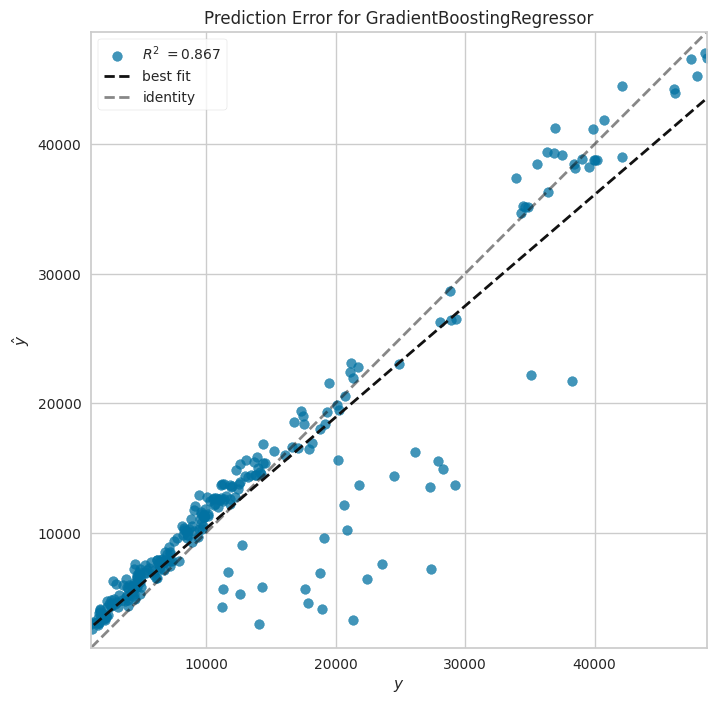

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

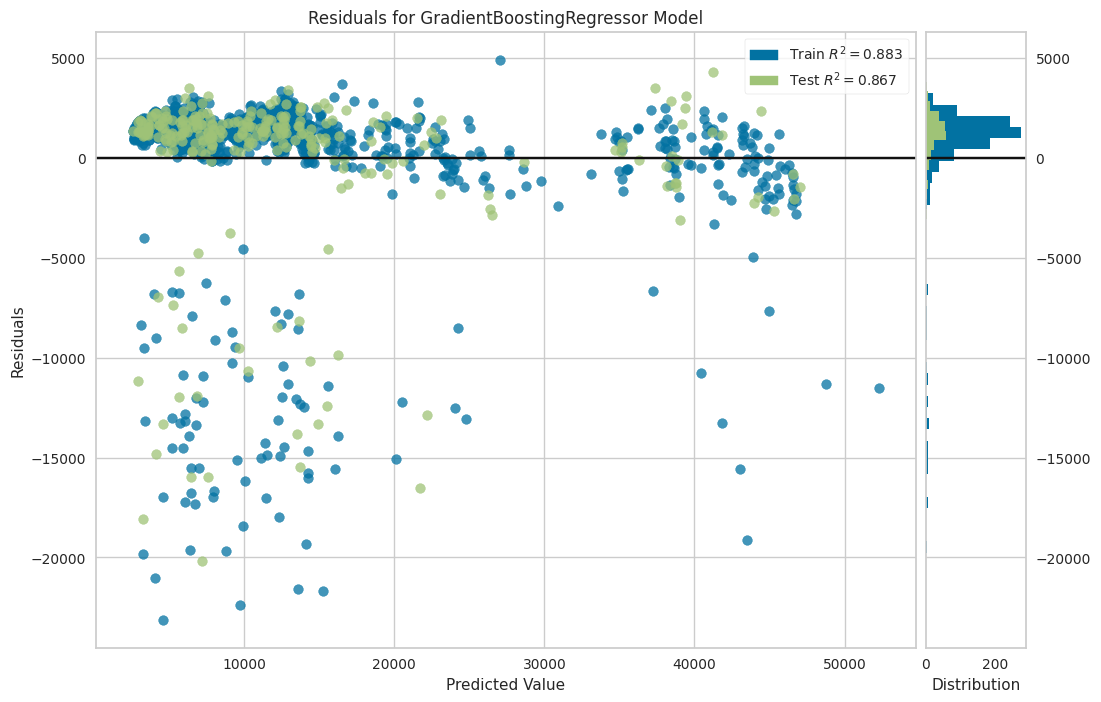

In [21]:
# Get tuned model
tuned_model_pipeline = grid_model.best_estimator_

# Get model predictions
y_pred = tuned_model_pipeline.predict(X_test)
model_metrics = get_metrics(y_test, y_pred)

# Get model parameters
model_params = tuned_model_pipeline.named_steps['model'].get_params()

# MLFlow
with mlflow.start_run():
    # Log métricas do modelo
    mlflow.log_metrics(model_metrics)
    # Log hiperparâmetros do mdoelo
    mlflow.log_params(model_params)
    # Log figures
    fig, ax = plt.subplots(figsize=(12,8))
    prediction_error(tuned_model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
    mlflow.log_figure(fig, artifact_file='plots/prediction_error.png')
    fig, ax = plt.subplots(figsize=(12,8))
    residuals_plot(tuned_model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
    mlflow.log_figure(fig, artifact_file='plots/residuals_plot.png')
    # Log modelo
    signature = infer_signature(X_test, tuned_model_pipeline.predict(X_test))
    mlflow.sklearn.log_model(tuned_model_pipeline, 'tuned_model_pipeline', registered_model_name='GradientBoostingRegressor', signature=signature)